In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [2]:
class_names = ['Cat', 'Dog'] 
n_dogs = len([name for name in os.listdir('train') if 'dog' in name.lower()])
n_cats = len([name for name in os.listdir('train') if 'cat' in name.lower()])
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [3]:
try:
    os.makedirs('/tmp/cats-v-dogs/training/cats', exist_ok=True)
    os.makedirs('/tmp/cats-v-dogs/training/dogs', exist_ok=True)
    os.makedirs('/tmp/cats-v-dogs/validation/cats', exist_ok=True)
    os.makedirs('/tmp/cats-v-dogs/validation/dogs', exist_ok=True)
    os.makedirs('/tmp/cats-v-dogs/test/cats', exist_ok=True)
    os.makedirs('/tmp/cats-v-dogs/test/dogs', exist_ok=True)
    print("All directories created successfully.")
except OSError as e:
    print(f"Error: {e}")


All directories created successfully.


In [4]:
CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

INCLUDE_TEST = True

In [5]:
SOURCE_DIR = "train"
TRAIN_CATS = "/tmp/cats-v-dogs/training/cats"
VALID_CATS = "/tmp/cats-v-dogs/validation/cats"
TEST_CATS = "/tmp/cats-v-dogs/test/cats"

TRAIN_DOGS = "/tmp/cats-v-dogs/training/dogs"
VALID_DOGS = "/tmp/cats-v-dogs/validation/dogs"
TEST_DOGS = "/tmp/cats-v-dogs/test/dogs"

os.makedirs(TRAIN_CATS, exist_ok=True)
os.makedirs(VALID_CATS, exist_ok=True)
os.makedirs(TEST_CATS, exist_ok=True)

os.makedirs(TRAIN_DOGS, exist_ok=True)
os.makedirs(VALID_DOGS, exist_ok=True)
os.makedirs(TEST_DOGS, exist_ok=True)

def prepare_split_data(label, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.2, 0.1), limit=1000):
    files = [f for f in os.listdir(SOURCE_DIR) if f.lower().startswith(label.lower()) and os.path.getsize(os.path.join(SOURCE_DIR, f)) > 0]
    random.shuffle(files)
    files = files[:limit]  

    n_train = int(len(files) * split_ratio[0])
    n_val = int(len(files) * split_ratio[1])

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for f in train_files:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(train_dir, f))
    for f in val_files:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(val_dir, f))
    for f in test_files:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(test_dir, f))


prepare_split_data('cat', TRAIN_CATS, VALID_CATS, TEST_CATS, limit=1000)
prepare_split_data('dog', TRAIN_DOGS, VALID_DOGS, TEST_DOGS, limit=1000)


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

9343
9342
2963
2973
1522
1521


In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): 
            files.append(file) 

    shuffled_files = random.sample(files,  len(files)) 
    split = int(0.9 * len(shuffled_files)) 
    train = shuffled_files[:split] 
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] 
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) 
    print("Split sucessful!")

In [8]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

9343
9342
2963
2973
1522
1521


In [9]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [10]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 18685 images belonging to 2 classes.
Found 5936 images belonging to 2 classes.
Found 5936 images belonging to 2 classes.


In [11]:
class_names = ['Cat', 'Dog']

def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance (e.g., train_generator)
    n_images : number of images to plot
    """
    images, labels = next(generator)  
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title("Cat" if labels[i] == 0 else "Dog")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


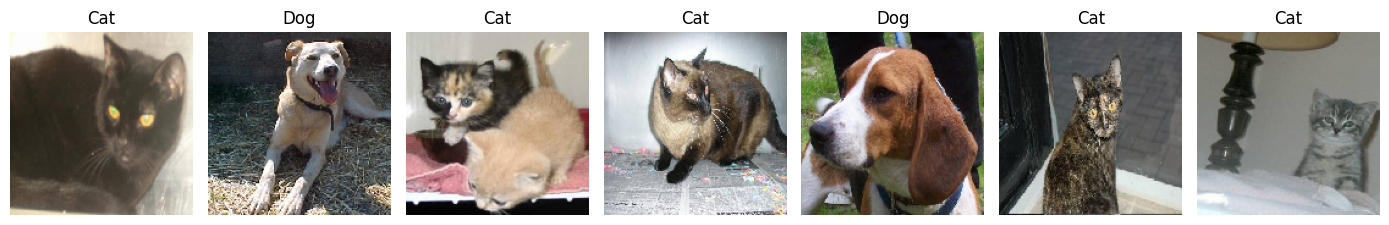

In [12]:
plot_data(train_generator,7)


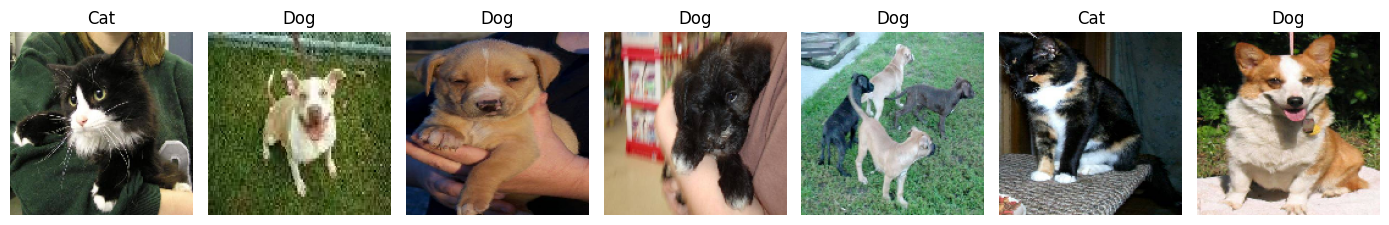

In [13]:
plot_data(validation_generator,7)


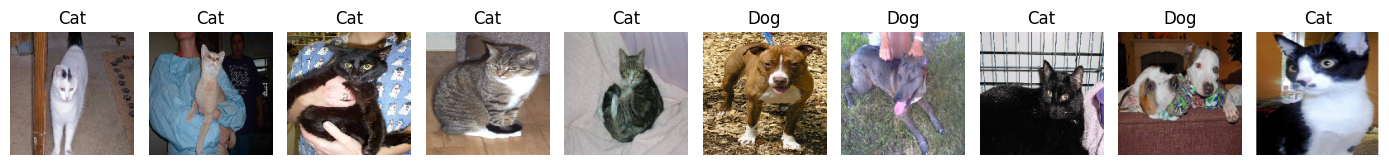

In [14]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [15]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:

r = model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 2813s 10s/step - accuracy: 0.5112 - loss: 0.6933 - val_accuracy: 0.6026 - val_loss: 0.6671
Epoch 2/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 2366s 8s/step - accuracy: 0.6047 - loss: 0.6664 - val_accuracy: 0.6115 - val_loss: 0.6444
Epoch 3/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 2913s 10s/step - accuracy: 0.6285 - loss: 0.6416 - val_accuracy: 0.6799 - val_loss: 0.5995
Epoch 4/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 2390s 8s/step - accuracy: 0.6630 - loss: 0.6122 - val_accuracy: 0.6880 - val_loss: 0.5878
Epoch 5/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 2486s 9s/step - accuracy: 0.6856 - loss: 0.5926 - val_accuracy: 0.6587 - val_loss: 0.6139


In [18]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

93/93 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6662 - loss: 0.6045


<a name="4-2"></a>

## Visualize the predicitons

In [21]:
import matplotlib.pyplot as plt

def plot_prediction(generator, n_images):
    """
    Plots predictions from the model
    Args:
    generator: data generator (e.g., test_generator)
    n_images : number of images to plot
    """
    images, labels = next(generator)  
    preds = model.predict(images)
    predicted_classes = preds.argmax(axis=1) if preds.shape[1] > 1 else (preds > 0.5).astype("int32")

    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {'Cat' if predicted_classes[i] == 0 else 'Dog'}\nTrue: {'Cat' if labels[i] == 0 else 'Dog'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


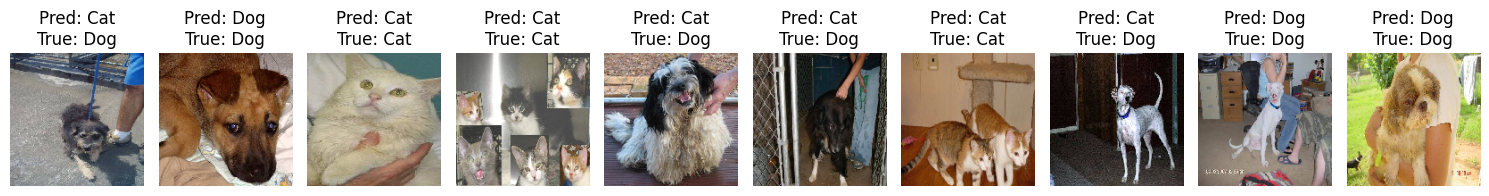

In [22]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


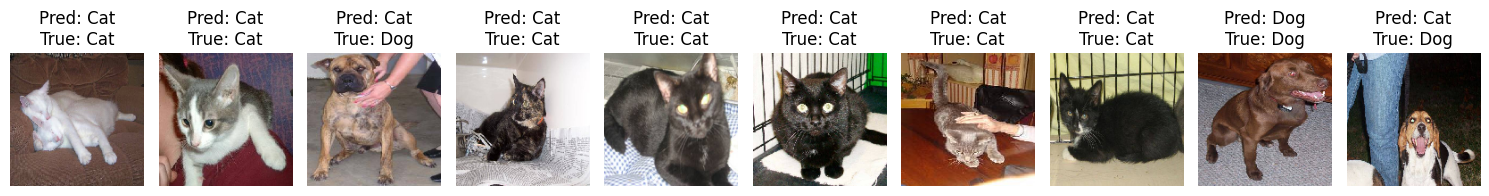

In [23]:
plot_prediction(validation_generator, 10)

In [26]:
gp_weights = model.get_layer('dense').get_weights()[0]

activation_model = Model(
    inputs=model.inputs,
    outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output)
)

In [27]:
images, _ = next(test_generator)

features, results = activation_model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [28]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    
    features_for_img = features[image_index,:,:,:]

    
    prediction = np.argmax(results[image_index])

    
    class_activation_weights = gp_weights[:,prediction]


    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    
    
    plt.imshow(images[image_index])

    
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    
    plt.show()

In [29]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated 
    '''
    counter = 0

    for i in range(0,10000):
        
        if counter == num_maps:
            break


        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

Predicted Class = Dog, Probability = 0.5438319


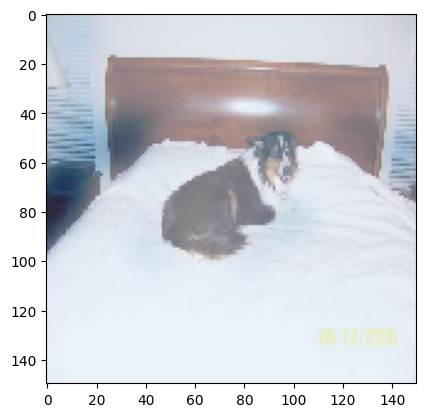

Predicted Class = Dog, Probability = 0.817111


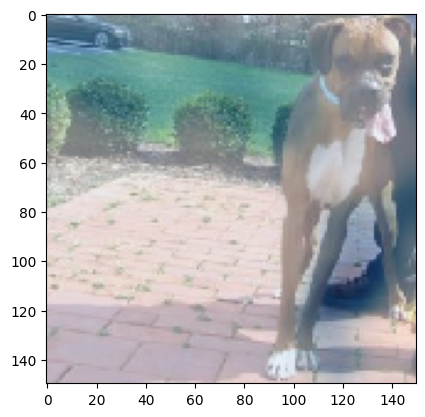

Predicted Class = Dog, Probability = 0.6098569


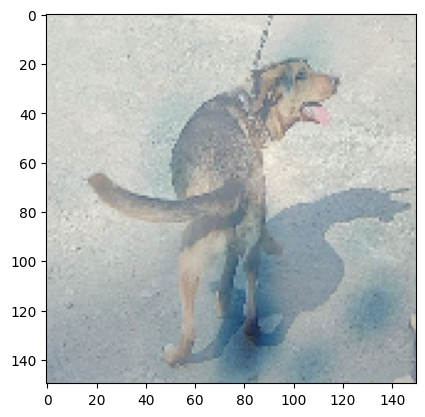

Predicted Class = Dog, Probability = 0.52339643


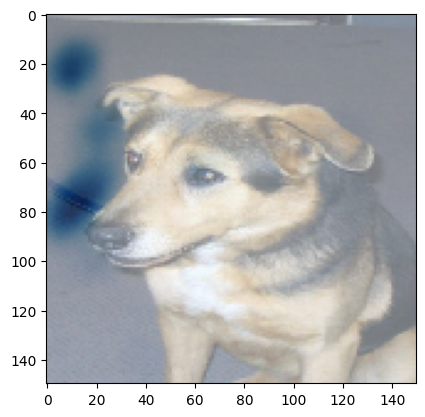

Predicted Class = Dog, Probability = 0.7316857


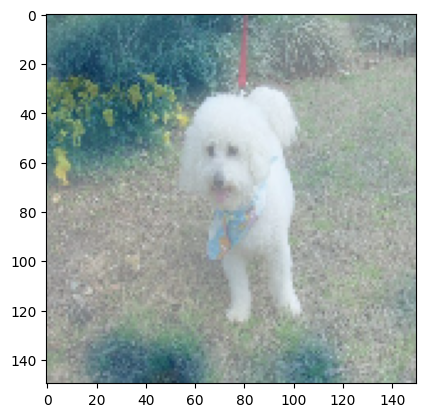

In [30]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.6632927


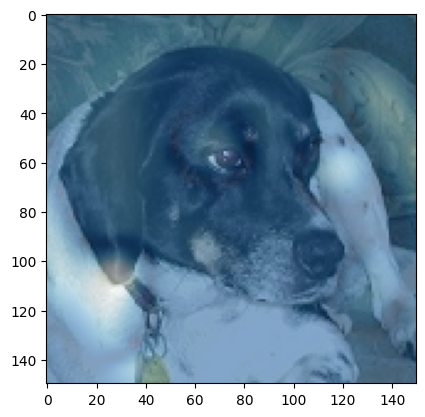

Predicted Class = Cat, Probability = 0.64188457


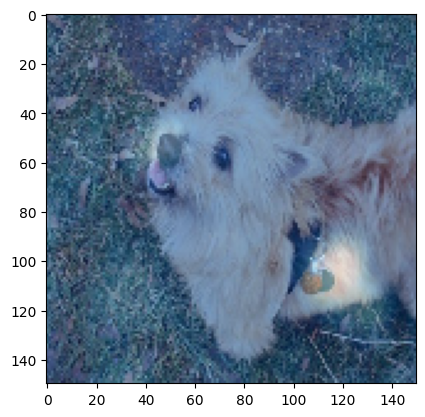

Predicted Class = Cat, Probability = 0.6664359


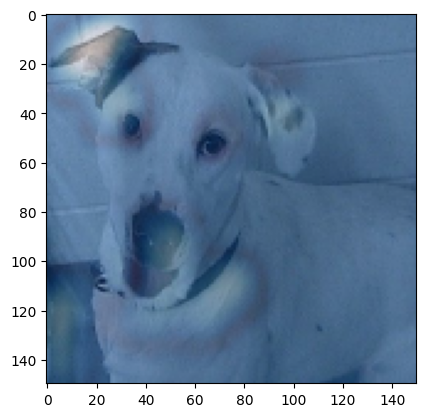

Predicted Class = Cat, Probability = 0.760482


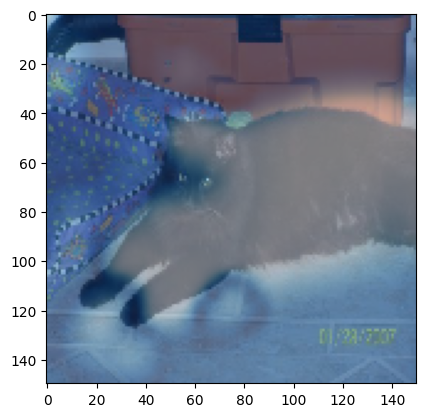

Predicted Class = Cat, Probability = 0.77492285


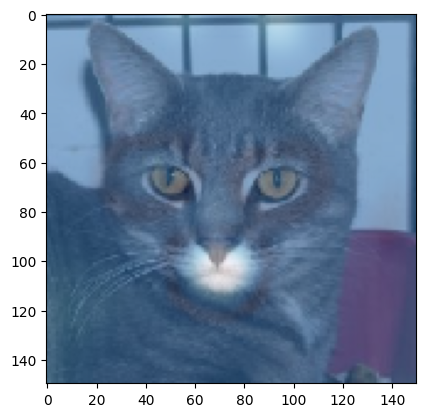

In [31]:
show_maps(desired_class=0, num_maps=5)